# Homework 2

Develop two Simple Moving Average strategies similar to what we discussed in class or what my Better_SMA.py script does.
You should select 4 tickers that have data from 1/1/2018 - 6/1/2021 (hint: pick tickers that work with bt.get)
Use 50 and 200 for the short and long moving averages for the first strategy.
For the second strategy, find a value for short and long that performs better than the 50 and 200 strategy. You will probably have to run your code several times to find a better strategy. Use the same tickers for both strategies.

In [1]:
import pandas as pd
import bt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import talib

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Moving Average Cross

A Reusable method taking the parameters of stock_tickers start and end period. We also take in to consideration the short term moving average period and long term moving average parameters. Finally Target Weight is going to represent the cross over weight 

In [3]:
def moving_average_cross(tickers, start_date, end_date, short_period, long_period, tgt_weight, graphs=False):
    # Price Data for the tickers in prescribed time period
    data = bt.get(tickers, start=start_date, end=end_date)
    # SMA for short and long term
    sma_short = data.rolling(short_period).mean()
    sma_long = data.rolling(long_period).mean()
    # Merge Long and ShortSMA
    if(graphs):
        plt.figure(figsize=(14,14))
        plot = bt.merge(data, sma_short, sma_long).plot(figsize=(15, 5), title='Data - Short term MA - Long term MA')
        plt.show()
    # Handle Target Weights
    target_weights = sma_long.copy()
    target_weights[sma_short > sma_long] =  tgt_weight
    target_weights[sma_short <= sma_long] = (-1 * tgt_weight)
    # Now set up the MA_cross strategy for our moving average cross strategy
    MA_cross = bt.Strategy('MA_cross', [bt.algos.WeighTarget(target_weights),
                                    bt.algos.Rebalance()])
    test_MA = bt.Backtest(MA_cross, data)
    # Run Strategy
    bt_result = bt.run(test_MA)
    # Run Bt Result
    return bt_result

### Handling Python bt result stats
Bt Results stats would return a pandas dataframe and <br/>we would translate that to a python dictionary for ease of computation

In [4]:
def bt_stats_to_dict(bt_results):
    df = bt_results.stats
    column = df.columns[0]
    return df.to_dict()[column]

### Core Parameters

For the purpose of this project we would consider the parameters CAGR, Sharpe Ration and Sortino Ratio and the function would return those values

In [5]:
def core_params(bt_results):
    dict = bt_stats_to_dict(bt_results)
    return round(dict['cagr']*100,2), round(dict['daily_sharpe']*100,2), round(dict['daily_sortino']*100,2)

### Asset Selection -
<b>Exxon Mobil, Tesla, Netflix, Apple</b><br/>
Start Dates and End Dates - as suggested in the home work <br/>
Defining the Moving Average Constants 

In [6]:
# Assets & Dates
tickers = 'xom, tsla, nflx, aapl'
start_date = '2018-01-01'
end_date = '2021-06-01'
# Moving Average Constants
short_period = 50
long_period = 200
tgt_weight = 0.2

### Find the Moving Average Crossing point

<Figure size 1008x1008 with 0 Axes>

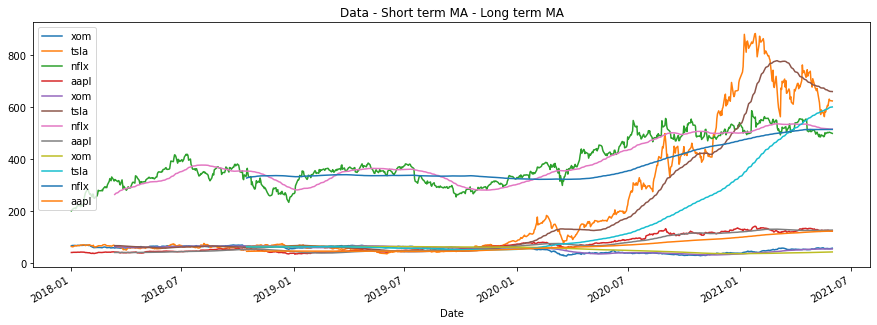

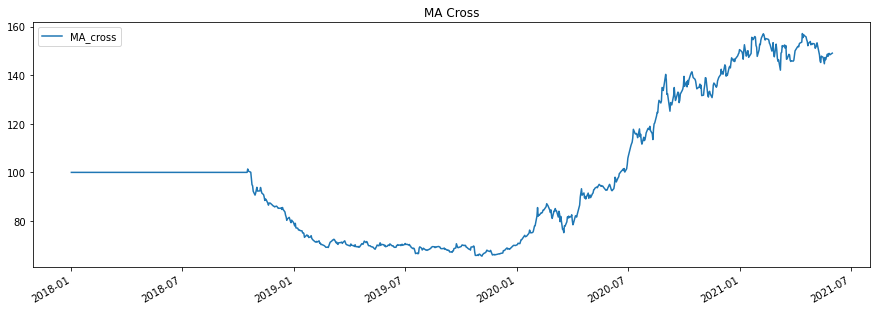

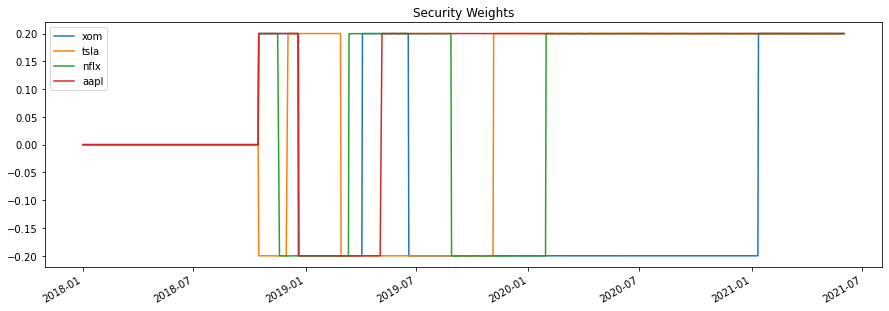

In [7]:
bt_result = moving_average_cross(tickers, start_date, end_date, short_period, 
                                 long_period, tgt_weight, True)

bt_result.plot(title='MA Cross')
plt.show()

bt_result.plot_security_weights(title='Security Weights')
plt.show()



### Printing Performance Paramters CAGR, SHARPE, SORTINO

In [8]:
print('--- Performance Parameters ---')
cagr, sharpe, sortino = core_params(bt_result)
print('CAGR - Sharpe - Sortino', cagr, sharpe, sortino)


--- Performance Parameters ---
CAGR - Sharpe - Sortino 12.41 71.6 116.89


## Find the Optimum Short and Long SMA

In [9]:
short_sma_lst = []
long_sma_lst = []
cagr_lst = []
sharpe_lst = []
sortino_lst = []
# Loop through sma short period and sma long period
for sma_long_index in range(150, 300, 5):
    for sma_short_index in range(20, 100, 5):
        bt_result = moving_average_cross(tickers, start_date, end_date, sma_short_index, sma_long_index, tgt_weight)
        cagr, sharpe, sortino = core_params(bt_result)
        # Add it to list
        short_sma_lst.append(sma_short_index)
        long_sma_lst.append(sma_long_index)
        cagr_lst.append(cagr)
        sharpe_lst.append(sharpe)
        sortino_lst.append(sortino)

# Get all the parameter list into a dataframe
df = pd.DataFrame({
    "sma_short": short_sma_lst,
    "sma_long": long_sma_lst,
    "cagr": cagr_lst,
    "sharpe": sharpe_lst,
    "sortino": sortino_lst
})
df

,sma_short,sma_long,cagr,sharpe,sortino
0,20,150,18.73,100.53,168.33
1,25,150,18.55,99.49,166.66
2,30,150,18.06,96.93,162.85
3,35,150,22.41,115.58,195.64
4,40,150,22.21,113.60,193.86
...,...,...,...,...,...
475,75,295,21.02,116.49,188.54
476,80,295,20.02,112.55,182.25
477,85,295,19.55,110.95,178.76
478,90,295,17.80,103.82,167.45


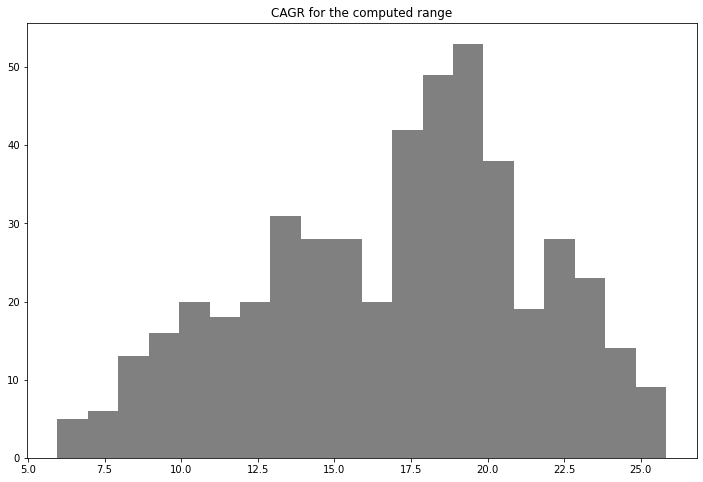

In [10]:
plt.figure(figsize=(12,8))
plt.title('CAGR for the computed range')
plt.hist(df['cagr'], bins=20, color='gray')
plt.show()

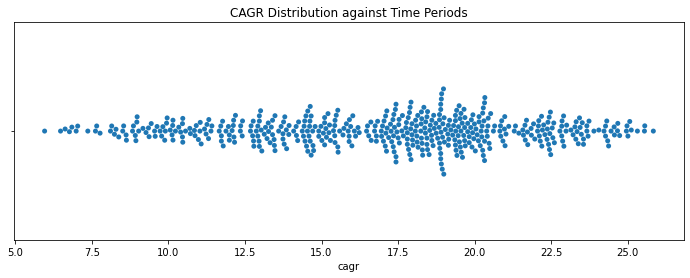

In [11]:
plt.figure(figsize=(12,4))
plt.title('CAGR Distribution against Time Periods')
sns.swarmplot(x=df['cagr'])
plt.show()

### Answer for the Home Work

SMA Short term would be <b>20 days</b><br/>
SMA Long term would be <b>290 days</b><br/>
CAGR for the above test case - <b>25.83%</b>

In [12]:
top_cagr_record = df.sort_values(by='cagr', ascending=False)[['sma_short', 'sma_long', 'cagr']].iloc[0].to_dict()
print('SMA_SHORT - ', top_cagr_record['sma_short'])
print('SMA_LONG - ', top_cagr_record['sma_long'])
print('CAGR - ', top_cagr_record['cagr'])

SMA_SHORT -  20.0
SMA_LONG -  290.0
CAGR -  25.83


### HeatMaps of Performance Parameters (CAGR - Sharpe)

In [13]:
def plot_heatmap(dataframe, index_vars, values, plttitle, aggfn=np.mean, ):
    pvt = pd.pivot_table(dataframe, index=index_vars,
                    values=values, aggfunc=np.mean)
    # Plot CAGR Pivot Table
    plt.figure(figsize=(12,12))
    plt.title(plttitle)
    sns.heatmap(pvt, cmap="RdBu")
    plt.show()

### Heat Map for Moving Averages Short & Long Vs CAGR

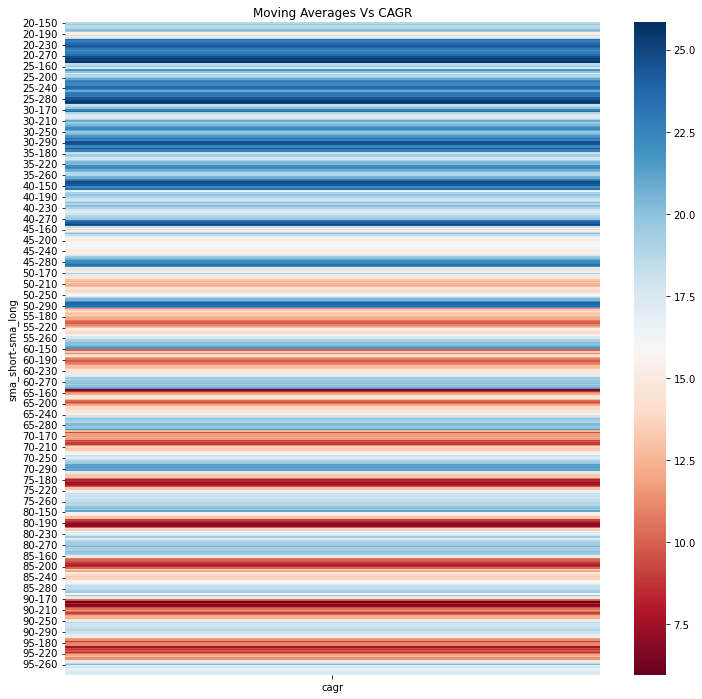

In [14]:
# Plot Moving Averages Vs CAGR 
plot_heatmap(df, ['sma_short', 'sma_long'], ['cagr'], 'Moving Averages Vs CAGR')

### Heat Map for Moving Averages Short & Long Vs Sharpe

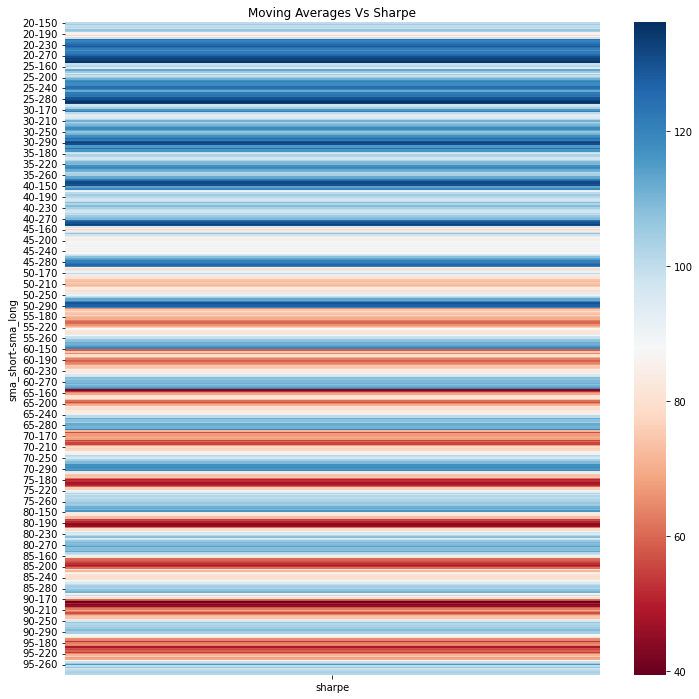

In [15]:
# Plot Moving Averages Vs Sharpe
plot_heatmap(df, ['sma_short', 'sma_long'], ['sharpe'], 'Moving Averages Vs Sharpe')